In [1]:
from utils import *

In [2]:
plt.rcParams["figure.facecolor"] = "white"

In [3]:
B,g0, b,ka=0.05, 0.3, 1, 1
R,S,H,_ = get_RSH_harmonic_onlyka(1,g0,b,ka)

In [7]:
# params - A,B,C,D,F,g0,b,ka
params = [
]

As = np.arange(-8,3.1,0.20)
As = As[As>=-4]

# As = np.arange(0.5,3.1,0.01)

params += [dict(A=A,B=B,g0=g0,b=b,ka=ka) for A in As]


df = pd.DataFrame(params, columns=["A","B","g0","b","ka"])

df["O+^2"],df["O-^2"] = omega_kumulant(df.A, df.B, df.g0, df.ka)

df["R"],df["S"],df["H"],df["varL"]=get_RSH_harmonic_onlyka(
                np.sqrt(df["O+^2"]),df.g0,df.b,df.ka)

In [8]:
df["S_init"] = df["S"]
df["R_init"] = df.R

df["H_init"] = df.H

In [9]:
df["S_init"] = 0
df["R_init"] = 0
df["H_init"] = 0

In [10]:
print(len(df));df.head()

36


,A,B,g0,b,ka,O+^2,O-^2,R,S,H,varL,S_init,R_init,H_init
0,-4.0,0.05,0.3,1,1,0.088760,-3.755427,20.443802,3.981267,-1.666667,168.340041,0,0,0
1,-3.8,0.05,0.3,1,1,0.093625,-3.560292,19.468126,3.989375,-1.666667,160.886887,0,0,0
2,-3.6,0.05,0.3,1,1,0.099038,-3.365705,18.495191,3.998397,-1.666667,153.457787,0,0,0
3,-3.4,0.05,0.3,1,1,0.105094,-3.171761,17.525470,4.008490,-1.666667,146.056908,0,0,0
4,-3.2,0.05,0.3,1,1,0.111910,-2.978577,16.559551,4.019850,-1.666667,138.689395,0,0,0


In [11]:
N=5000000
warmup=0
dt=0.001
samples=1000
skip=10000
runs=4
time = np.linspace(0,N//skip *dt, N//skip)

dump_to_disk = False

In [14]:
results = np.load("dumps/results.npy")[-len(df):]

In [15]:
results[:,:,:,:].shape

(36, 9, 2000, 2500)

### Start Analisys

In [16]:
cov_all = np.einsum("iakj,ibkj->ijab", results[:,:6,:,:],results[:,:6,:,:],optimize=True)/(results.shape[2]-1)
cov = cov_all[:, :1000]
# cov = cov[df[df.b].index]

In [17]:
sp = 10
cov_R = cov[:,::sp,(0,1),(0,1)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_Rz = cov[:,::sp,(2,),(2,)].transpose(1,0,2).reshape(-1, cov.shape[0])

cov_S = cov[:,::sp,(3,4),(3,4)].transpose(1,0,2).reshape(-1, cov.shape[0]*2)
cov_Sz = cov[:,::sp,(5,),(5,)].transpose(1,0,2).reshape(-1, cov.shape[0])

cov_H = cov[:,::sp,(0,1,3,4),(4,3,1,0)].transpose(1,0,2).reshape(-1, cov.shape[0]*4)

cov_Zero = cov[:,::sp,(0,0,1,1,2,2,3,3),(1,2,0,3,0,3,1,2)].transpose(1,0,2).reshape(-1, cov.shape[0]*8)

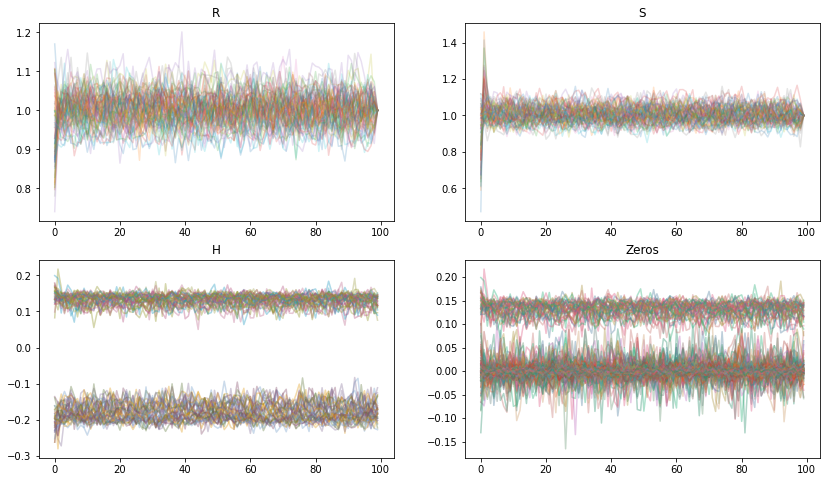

In [18]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.plot(cov_R/cov_R[-1], alpha=0.2);plt.title("R")
plt.subplot(2,2,2)
plt.plot(cov_S/cov_S[-1], alpha=0.2);plt.title("S")
plt.subplot(2,2,3)
plt.plot(cov_H/(10+cov_H[-1]), alpha=0.2);plt.title("H")
plt.subplot(2,2,4)
plt.plot(cov_Zero/(10+cov_Zero[-1]), alpha=0.2);plt.title("Zeros");

In [19]:
stationari_treshold = 100

In [20]:
cov_mean, cov_err = mean_with_err(cov_all[:, stationari_treshold:], axis=1)

In [21]:
cov_mean.shape

(36, 6, 6)

In [22]:
df["xx"], df["xx_err"]= cov_mean[:,0,0], cov_err[:,0,0]
df["xy"], df["xy_err"]= cov_mean[:,0,1], cov_err[:,0,1]
df["xz"], df["xz_err"]= cov_mean[:,0,2], cov_err[:,0,2]

df["yy"], df["yy_err"]= cov_mean[:,1,1], cov_err[:,1,1]
df["zz"], df["zz_err"]= cov_mean[:,2,2], cov_err[:,2,2]

df["vxvx"], df["vxvx_err"]= cov_mean[:,3,3], cov_err[:,3,3]
df["vyvy"], df["vyvy_err"]= cov_mean[:,4,4], cov_err[:,4,4]
df["vzvz"], df["vzvz_err"]= cov_mean[:,5,5], cov_err[:,5,5]

df["xvy"], df["xvy_err"]= cov_mean[:,0,4], cov_err[:,0,4]
df["yvx"], df["yvx_err"]= cov_mean[:,1,3], cov_err[:,1,3]
df["xvx"], df["xvx_err"]= cov_mean[:,0,3], cov_err[:,0,3]

df["xvz"], df["xvz_err"]= cov_mean[:,0,5], cov_err[:,0,5]
df["zvz"], df["zvz_err"]= cov_mean[:,2,5], cov_err[:,2,5]


df["vxvy"], df["vxvy_err"]= cov_mean[:,3,4], cov_err[:,3,4]
df["vxvz"], df["vxvz_err"]= cov_mean[:,3,5], cov_err[:,3,5]

## xry analysis

In [23]:
results.shape

(36, 9, 2000, 2500)

In [24]:
x,y,z,vx,vy,vz,rx,ry,rz = results[...,stationari_treshold::].transpose(1,0,2,3)

ux, uy, uz = [], [], []
for row in df.itertuples():
    i = row.Index
    ux_, uy_, uz_ = Uxyz_1(row.A, row.B, x[i].flatten(),y[i].flatten() ,z[i].flatten() )
    ux.append(ux_.reshape(x.shape[1], x.shape[2]))
    uy.append(uy_.reshape(x.shape[1], x.shape[2]))
    uz.append(uz_.reshape(x.shape[1], x.shape[2]))

ux=np.array(ux)
uy=np.array(uy)
uz=np.array(uz)

In [26]:
df["xvy"], df["xvy_err"]=mean_with_err((x*vy).reshape(x.shape[0],-1), axis=1)
df["xry"], df["xry_err"]=mean_with_err((x*ry).reshape(x.shape[0],-1), axis=1)

df["uxry"], df["uxry_err"]=mean_with_err((ux*ry).reshape(x.shape[0],-1), axis=1)
df["uyrx"], df["uyrx_err"]=mean_with_err((uy*rx).reshape(x.shape[0],-1), axis=1)

df["uzvz"], df["uzvz_err"]=mean_with_err((uz*vz).reshape(x.shape[0],-1), axis=1)
df["uxvx"], df["uxvx_err"]=mean_with_err((ux*vx).reshape(x.shape[0],-1), axis=1)

In [27]:
df["xvy"], df["xvy_err"]=mean_with_err(np.mean(x*vy, axis=1), axis=1)
df["xry"], df["xry_err"]=mean_with_err(np.mean(x*ry, axis=1), axis=1)

df["uxry"], df["uxry_err"]=mean_with_err(np.mean(ux*ry, axis=1), axis=1)
df["uyrx"], df["uyrx_err"]=mean_with_err(np.mean(uy*rx, axis=1), axis=1)

df["uzvz"], df["uzvz_err"]=mean_with_err(np.mean(uz*vz, axis=1), axis=1)
df["uxvx"], df["uxvx_err"]=mean_with_err(np.mean(ux*vx, axis=1), axis=1)


## Some plots

In [28]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

In [29]:
values = results[:,:2,:,stationari_treshold:].reshape(results.shape[0],-1)
moment2 = np.mean(values**2, axis=1)
moment3 = np.mean(values**3, axis=1)
moment4 = np.mean(values**4, axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


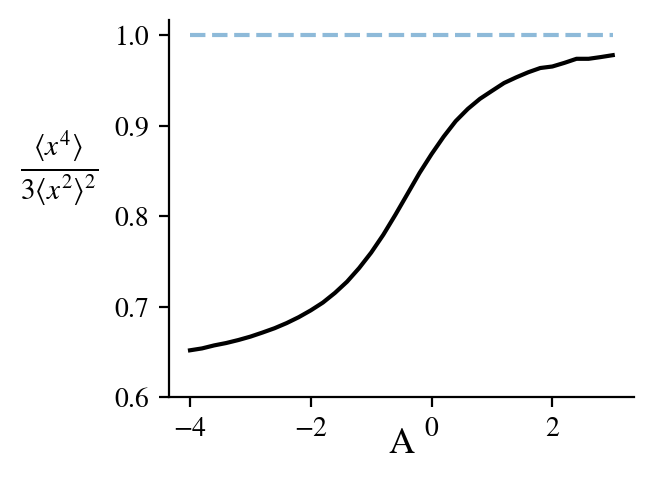

In [31]:
plt.figure(figsize=(3,2.5), dpi=200)
plt.plot(df.A,moment4/moment2**2/3, c="k")
plt.hlines(y=1, xmin=min(df.A), xmax=max(df.A), ls="--", alpha=0.5)
# plt.title("moments ratio for position")
plt.yticks(np.arange(0.6,1.01,0.1))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel("A",fontdict={"size":13},labelpad=-5)
plt.ylabel(r"$\frac{\langle x^4\rangle}{3 \langle x^2\rangle^2}$", rotation=0, labelpad=20,  fontsize=15)
plt.savefig("./figuregen/cumulant_check.eps", bbox_inches = 'tight',
    pad_inches = 0.08)

In [32]:
del moment2, moment3, moment4

### Plots to publish

In [34]:
from nsdesolve import U_2

In [35]:
factor = 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


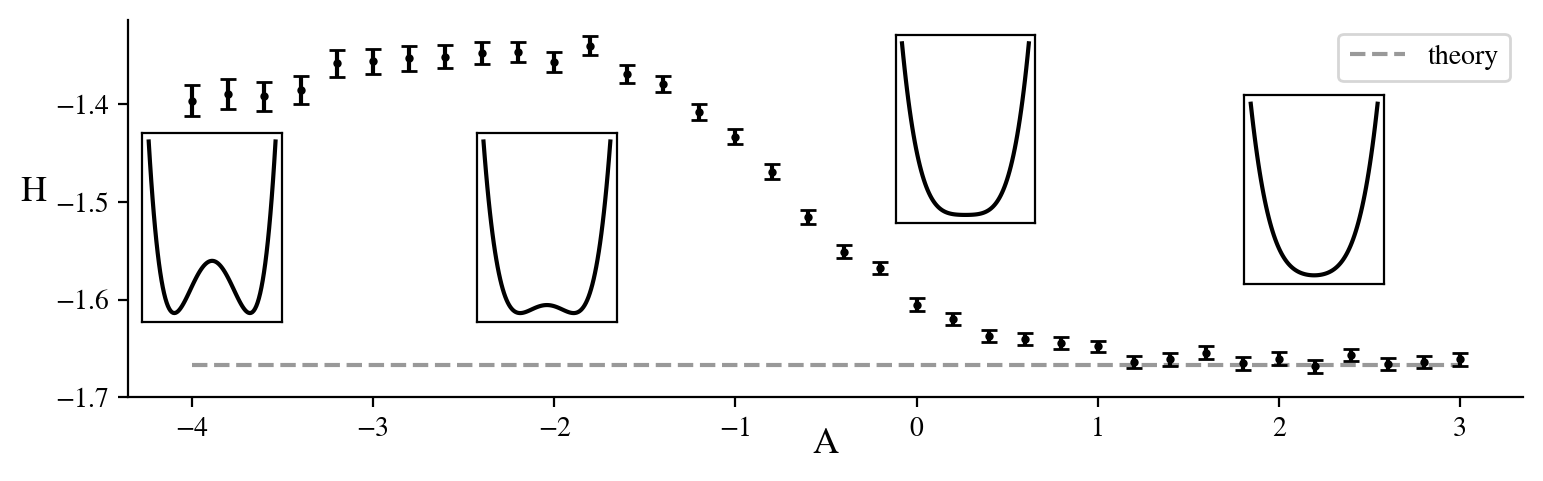

In [37]:
plt.figure(figsize=(9,2.5), dpi=200)

plt.plot(df.A, df["H"],"--",label=f"theory", c="k", alpha=0.4)

plt.errorbar(df.A, df["xvy"], yerr=df["xvy_err"]*factor, capsize=3, marker="o", ls="none", ms=2,
                c="k")
plt.xlabel("A",labelpad=-5,fontdict={"size":13})
plt.ylabel("H",rotation=0,labelpad=8,fontdict={"size":13})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.yticks(np.arange(-1.70,-1.31, 0.1))
ins = plt.gca().inset_axes([0.01,0.2,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(-4,B, 0,0,0, r, np.zeros_like(r)), c="k");


ins = plt.gca().inset_axes([0.25,0.2,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(-2,B, 0,0,0, r, np.zeros_like(r)), c="k");

ins = plt.gca().inset_axes([0.55,0.46,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(0.5,B, 0,0,0, r, np.zeros_like(r)), c="k");

ins = plt.gca().inset_axes([0.8,0.3,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(2.3,B, 0,0,0, r, np.zeros_like(r)), c="k");

plt.legend()
plt.savefig("./figuregen/H_plot.eps", bbox_inches = 'tight', pad_inches = 0.08)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


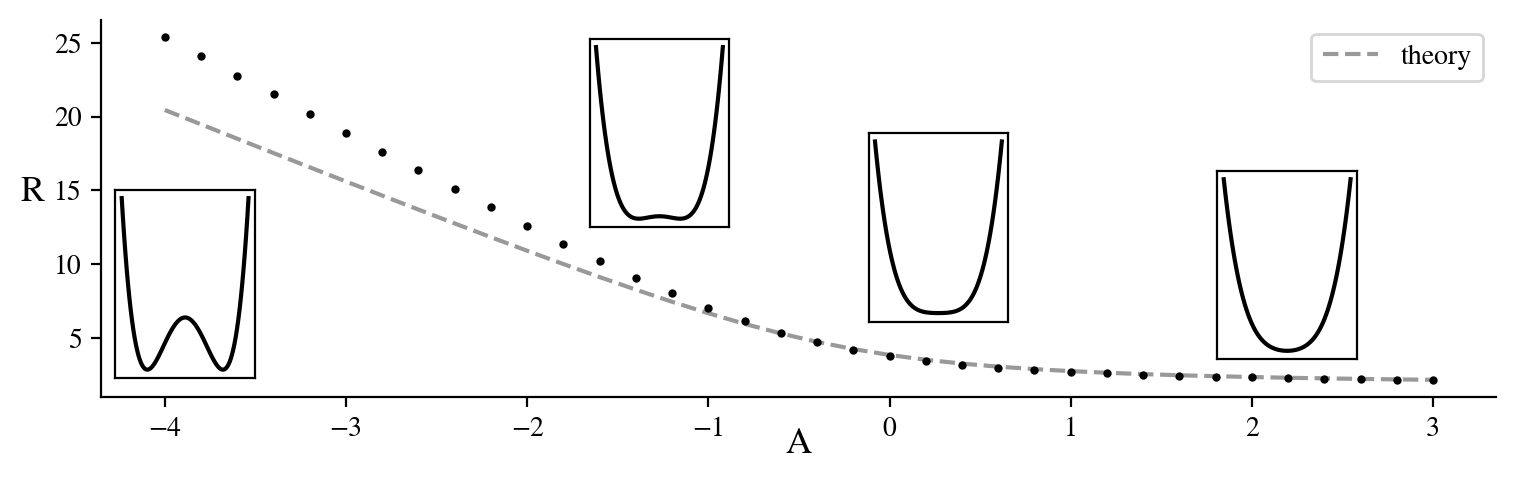

In [38]:
plt.figure(figsize=(9,2.5), dpi=200)

plt.plot(df.A, df["R"],"--",label=f"theory", c="k", alpha=0.4)

# plt.errorbar(df.A, df["xx"], yerr=df["xx_err"]*factor, capsize=5, marker="o", ls="none", ms=2,
#                 c="k")
plt.plot(df.A, df["xx"], marker="o", ls="none", ms=2, c="k")

plt.xlabel("A",labelpad=-5,fontdict={"size":13})
plt.ylabel("R",rotation=0,labelpad=8,fontdict={"size":13})
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.yticks(np.arange(-1.70,-1.31, 0.1))

ins = plt.gca().inset_axes([0.01,0.05,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(-4,B, 0,0,0, r, np.zeros_like(r)), c="k");


ins = plt.gca().inset_axes([0.35,0.45,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(-1.2,B, 0,0,0, r, np.zeros_like(r)), c="k");

ins = plt.gca().inset_axes([0.55,0.2,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(0.5,B, 0,0,0, r, np.zeros_like(r)), c="k");

ins = plt.gca().inset_axes([0.8,0.1,0.1,0.5])
ins.set_xticks([])
ins.set_yticks([])
r = np.linspace(-15,15,100)
ins.plot(r, U_2(2.3,B, 0,0,0, r, np.zeros_like(r)), c="k");

plt.legend()
plt.savefig("./figuregen/R_plot.eps",bbox_inches = 'tight',
    pad_inches = 0.08)